# Prediction model and Feature importance

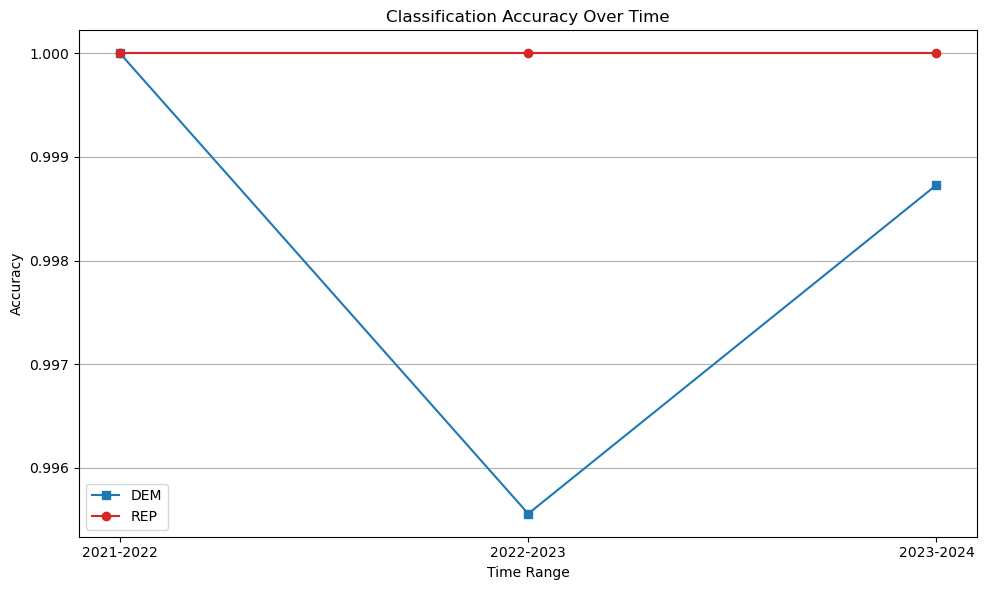

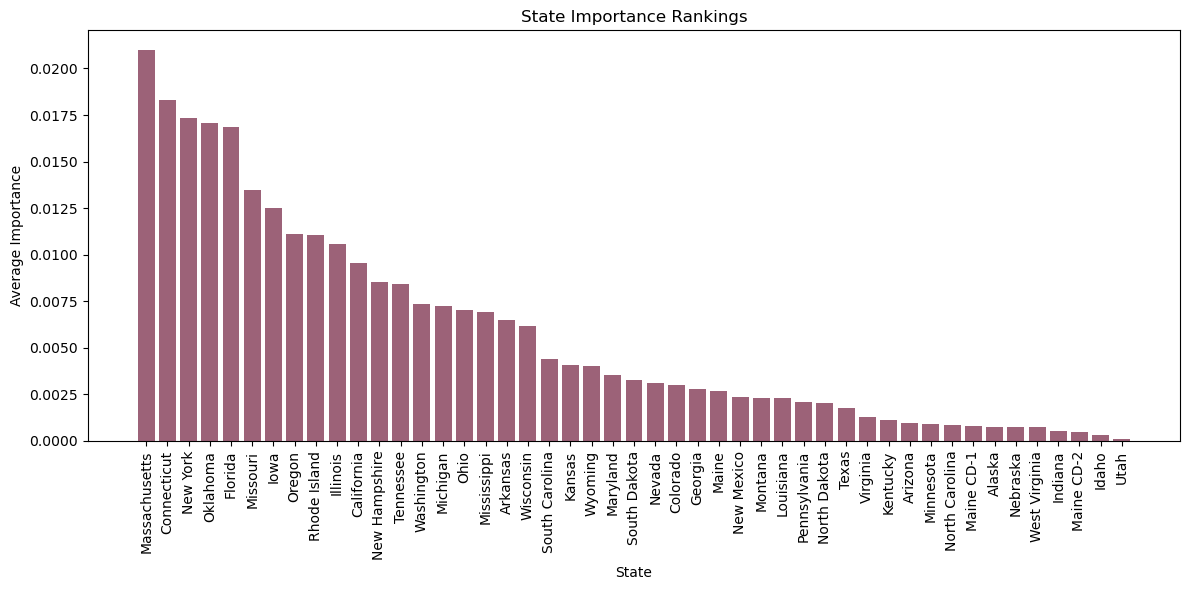

/var/folders/jw/chhn8bwd1sv2c_kncfq_rfl00000gp/T/ipykernel_46411/3873590724.py:230: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plt.plot(dem_grouped_data['start_date'][::15], dem_model.predict(dem_X_train.append(dem_X_test))[::15], label='DEM Model', color='C0')
/var/folders/jw/chhn8bwd1sv2c_kncfq_rfl00000gp/T/ipykernel_46411/3873590724.py:233: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plt.plot(rep_grouped_data['start_date'][::15], rep_model.predict(rep_X_train.append(rep_X_test))[::15], label='REP Model', color='C3')


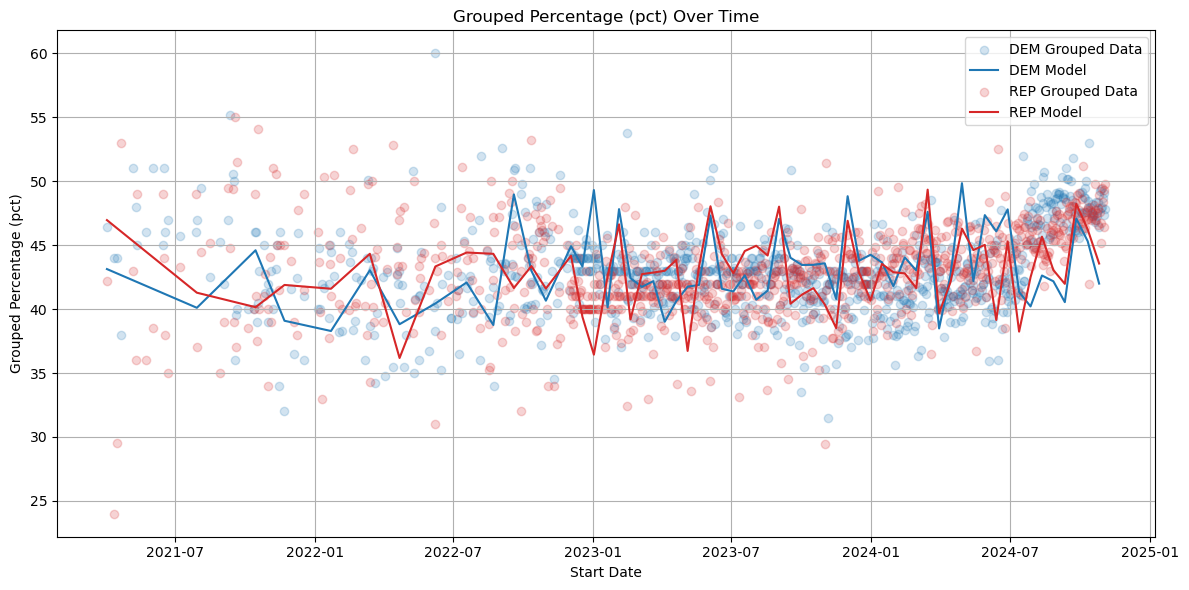

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
import matplotlib.pyplot as plt
from typing import List, Tuple, Union, Dict

class ElectionAnalysis:
    def __init__(self, data_path: str):
        self.data = pd.read_csv(data_path)
        self.data['start_date'] = pd.to_datetime(self.data['start_date'])
        self.data['end_date'] = pd.to_datetime(self.data['end_date'])
        self.one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')

    def filter_data(self, start_year: int, end_year: int) -> pd.DataFrame:
        return self.data[(self.data['start_date'].dt.year >= start_year) & 
                         (self.data['end_date'].dt.year < end_year)]

    def filter_by_party(self, party: str) -> pd.DataFrame:
        return self.data[self.data['party'] == party]

    def train_classification_model(self, data: pd.DataFrame, target_party: str) -> Tuple[float, np.ndarray, pd.DataFrame]:
        encoded_features = self.one_hot_encoder.fit_transform(
            data[['party', 'answer', 'state']].fillna("Unknown")
        )
        feature_names = self.one_hot_encoder.get_feature_names_out(['party', 'answer', 'state'])

        X = pd.DataFrame(encoded_features, columns=feature_names)
        y = (data['party'] == target_party).astype(int)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = RandomForestClassifier(random_state=42)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': model.feature_importances_
        }).sort_values(by='Importance', ascending=False)

        feature_importance = feature_importance[~feature_importance['Feature'].str.contains('Unknown')]
        feature_importance['Importance'] /= feature_importance['Importance'].sum()

        return accuracy, cm, feature_importance

    def train_regression_model(self, data: pd.DataFrame) -> Tuple[float, pd.DataFrame]:
        encoded_features = self.one_hot_encoder.fit_transform(
            data[['party', 'answer', 'state']].fillna("Unknown")
        )
        feature_names = self.one_hot_encoder.get_feature_names_out(['party', 'answer', 'state'])

        X = pd.DataFrame(encoded_features, columns=feature_names)
        y = data['pct']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = RandomForestRegressor(random_state=42)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)

        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': model.feature_importances_
        }).sort_values(by='Importance', ascending=False)

        feature_importance = feature_importance[~feature_importance['Feature'].str.contains('Unknown')]
        feature_importance['Importance'] /= feature_importance['Importance'].sum()

        return mse, feature_importance

    def analyze_time_ranges(self, time_ranges: List[Tuple[int, int]], task: str = "classification", target_party: str = "DEM") -> List[Dict[str, Union[str, float, pd.DataFrame]]]:
        results = []

        for start, end in time_ranges:
            filtered_data = self.filter_data(start, end)
            if filtered_data.empty:
                continue

            if task == "classification":
                accuracy, cm, importance = self.train_classification_model(filtered_data, target_party)
                results.append({
                    'Time Range': f"{start}-{end}",
                    'Accuracy': accuracy,
                    'Confusion Matrix': cm,
                    'Feature Importance': importance
                })
            elif task == "regression":
                mse, importance = self.train_regression_model(filtered_data)
                results.append({
                    'Time Range': f"{start}-{end}",
                    'MSE': mse,
                    'Feature Importance': importance
                })

        return results

    def visualize_results(self, dem_results: List[Dict[str, Union[str, float]]], rep_results: List[Dict[str, Union[str, float]]], metric: str, title: str):
        dem_time_range_labels = [result['Time Range'] for result in dem_results]
        dem_metrics = [result[metric] for result in dem_results]

        rep_time_range_labels = [result['Time Range'] for result in rep_results]
        rep_metrics = [result[metric] for result in rep_results]

        plt.figure(figsize=(10, 6))
        plt.plot(dem_time_range_labels, dem_metrics, marker='s', linestyle='-', color='C0', label='DEM')
        plt.plot(rep_time_range_labels, rep_metrics, marker='o', linestyle='-', color='C3', label='REP')

        plt.title(title)
        plt.xlabel('Time Range')
        plt.ylabel(metric)
        plt.legend()
        plt.grid(axis='y')
        plt.tight_layout()
        plt.show()

    def rank_state_importance(self, dem_results: List[Dict[str, Union[str, pd.DataFrame]]], rep_results: List[Dict[str, Union[str, pd.DataFrame]]]):
        dem_state_importance = {}
        rep_state_importance = {}

        for result in dem_results:
            importance = result['Feature Importance']
            state_features = importance[importance['Feature'].str.contains('state_')]

            for _, row in state_features.iterrows():
                state = row['Feature'].replace('state_', '')
                if state not in dem_state_importance:
                    dem_state_importance[state] = []
                dem_state_importance[state].append(row['Importance'])

        for result in rep_results:
            importance = result['Feature Importance']
            state_features = importance[importance['Feature'].str.contains('state_')]

            for _, row in state_features.iterrows():
                state = row['Feature'].replace('state_', '')
                if state not in rep_state_importance:
                    rep_state_importance[state] = []
                rep_state_importance[state].append(row['Importance'])

        dem_avg_importance = {
            state: np.mean(importances) for state, importances in dem_state_importance.items()
        }

        rep_avg_importance = {
            state: np.mean(importances) for state, importances in rep_state_importance.items()
        }

        dem_df = pd.DataFrame({
            'State': list(dem_avg_importance.keys()),
            'Average Importance': list(dem_avg_importance.values())
        }).sort_values(by='Average Importance', ascending=False)

        rep_df = pd.DataFrame({
            'State': list(rep_avg_importance.keys()),
            'Average Importance': list(rep_avg_importance.values())
        }).sort_values(by='Average Importance', ascending=False)

        fig, ax = plt.subplots(figsize=(12, 6))
        ax.bar(dem_df['State'], dem_df['Average Importance'], color='C0', alpha=0.7, label='DEM')
        ax.bar(rep_df['State'], rep_df['Average Importance'], color='C3', alpha=0.5, label='REP')

        ax.set_title('State Importance Rankings')
        ax.set_xlabel('State')
        ax.set_ylabel('Average Importance')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()
    
    def plot_pct_over_time(self, dem_data: pd.DataFrame, rep_data: pd.DataFrame):
        def prepare_data(data):
            data = data.sort_values(by='start_date')
            X = data[['start_date']].copy()
            X['start_date'] = X['start_date'].map(lambda x: x.timestamp())
            y = data['pct']
            return train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=data['start_date'].dt.year)

        dem_X_train, dem_X_test, dem_y_train, dem_y_test = prepare_data(dem_data)
        rep_X_train, rep_X_test, rep_y_train, rep_y_test = prepare_data(rep_data)

        dem_model = RandomForestRegressor(random_state=42)
        dem_model.fit(dem_X_train, dem_y_train)

        rep_model = RandomForestRegressor(random_state=42)
        rep_model.fit(rep_X_train, rep_y_train)

        plt.figure(figsize=(12, 6))

        plt.scatter(dem_data['start_date'], dem_data['pct'], label='DEM Data', color='C0', alpha=0.5)
        plt.plot(dem_data['start_date'], dem_model.predict(dem_X_train.append(dem_X_test)), label='DEM Model', color='C0')

        plt.scatter(rep_data['start_date'], rep_data['pct'], label='REP Data', color='C3', alpha=0.5)
        plt.plot(rep_data['start_date'], rep_model.predict(rep_X_train.append(rep_X_test)), label='REP Model', color='C3')

        plt.title('Percentage (pct) Over Time')
        plt.xlabel('Start Date')
        plt.ylabel('Percentage (pct)')
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()

    def plot_grouped_pct_over_time(self, dem_data: pd.DataFrame, rep_data: pd.DataFrame):
        def prepare_grouped_data(data):
            grouped_data = data.groupby('start_date').agg({'pct': 'mean'}).reset_index()
            X = grouped_data[['start_date']].copy()
            X['start_date'] = X['start_date'].map(lambda x: x.timestamp())
            y = grouped_data['pct']
            return grouped_data, train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=grouped_data['start_date'].dt.year)

        dem_grouped_data, (dem_X_train, dem_X_test, dem_y_train, dem_y_test) = prepare_grouped_data(dem_data)
        rep_grouped_data, (rep_X_train, rep_X_test, rep_y_train, rep_y_test) = prepare_grouped_data(rep_data)

        dem_model = RandomForestRegressor(random_state=42)
        dem_model.fit(dem_X_train, dem_y_train)

        rep_model = RandomForestRegressor(random_state=42)
        rep_model.fit(rep_X_train, rep_y_train)

        plt.figure(figsize=(12, 6))

        plt.scatter(dem_grouped_data['start_date'], dem_grouped_data['pct'], label='DEM Grouped Data', color='C0', alpha=0.2)
        plt.plot(dem_grouped_data['start_date'][::15], dem_model.predict(dem_X_train.append(dem_X_test))[::15], label='DEM Model', color='C0')

        plt.scatter(rep_grouped_data['start_date'], rep_grouped_data['pct'], label='REP Grouped Data', color='C3', alpha=0.2)
        plt.plot(rep_grouped_data['start_date'][::15], rep_model.predict(rep_X_train.append(rep_X_test))[::15], label='REP Model', color='C3')

        plt.title('Grouped Percentage (pct) Over Time')
        plt.xlabel('Start Date')
        plt.ylabel('Grouped Percentage (pct)')
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()


# Load the dataset and run the analysis
data_path = '/Users/donghaozheng/Princeton/Course/second_year_fall/APC524/HOMEWORK/HW3_project/president_polls_cleaned.csv'

# Initialize the ElectionAnalysis class
analysis = ElectionAnalysis(data_path)

# Split data by party
dem_data = analysis.filter_by_party("DEM")
rep_data = analysis.filter_by_party("REP")

# Time ranges for analysis
time_ranges = [(2021, 2022), (2022, 2023), (2023, 2024)]

# Analyze classification performance over time ranges
dem_classification_results = analysis.analyze_time_ranges(time_ranges, task="classification", target_party="DEM")
rep_classification_results = analysis.analyze_time_ranges(time_ranges, task="classification", target_party="REP")

# Visualize classification results
analysis.visualize_results(dem_classification_results, rep_classification_results, metric="Accuracy", title="Classification Accuracy Over Time")

# Analyze regression performance over time ranges
dem_regression_results = analysis.analyze_time_ranges(time_ranges, task="regression")
rep_regression_results = analysis.analyze_time_ranges(time_ranges, task="regression")

# Rank state importance and visualize
analysis.rank_state_importance(dem_regression_results, rep_regression_results)

# Plot grouped pct over time
analysis.plot_grouped_pct_over_time(dem_data, rep_data)

In [ ]:
import unittest
import pandas as pd
from unittest.mock import patch, MagicMock
from io import StringIO
import numpy as np
from typing import List, Dict, Tuple

class TestElectionAnalysis(unittest.TestCase):
    def setUp(self) -> None:
        # Mock dataset
        self.mock_csv_data: StringIO = StringIO(
            """start_date,end_date,party,answer,state,candidate_name,pct
            2021-01-01,2021-01-10,DEM,Yes,California,Joe Biden,55.0
            2021-01-11,2021-01-20,REP,No,Texas,Donald Trump,45.0
            2022-01-01,2022-01-10,DEM,Yes,New York,Joe Biden,60.0
            2022-01-11,2022-01-20,REP,No,Florida,Donald Trump,50.0
            2023-01-01,2023-01-10,DEM,Yes,Illinois,Joe Biden,53.0
            2023-01-11,2023-01-20,REP,No,Ohio,Donald Trump,47.0
            """
        )
        self.mock_data_path: str = "mock_data.csv"
        self.mock_data: pd.DataFrame = pd.read_csv(self.mock_csv_data)

        # Patch read_csv to return mock data
        self.patcher = patch('pandas.read_csv', return_value=self.mock_data)
        self.mock_read_csv: MagicMock = self.patcher.start()

        # Initialize the analysis class
        self.analysis: ElectionAnalysis = ElectionAnalysis(self.mock_data_path)

    def tearDown(self) -> None:
        self.patcher.stop()

    def test_filter_data(self) -> None:
        filtered_data: pd.DataFrame = self.analysis.filter_data(2021, 2022)
        self.assertEqual(len(filtered_data), 2)
        self.assertTrue((filtered_data['start_date'].dt.year >= 2021).all())
        self.assertTrue((filtered_data['end_date'].dt.year < 2022).all())

    def test_filter_by_party(self) -> None:
        dem_data: pd.DataFrame = self.analysis.filter_by_party("DEM")
        rep_data: pd.DataFrame = self.analysis.filter_by_party("REP")
        self.assertEqual(len(dem_data), 3)
        self.assertEqual(len(rep_data), 3)

    def test_train_classification_model(self) -> None:
        dem_data: pd.DataFrame = self.analysis.filter_by_party("DEM")
        accuracy: float
        cm: np.ndarray
        importance: pd.DataFrame
        accuracy, cm, importance = self.analysis.train_classification_model(dem_data, "DEM")
        self.assertIsInstance(accuracy, float)
        self.assertIsInstance(cm, np.ndarray)
        self.assertIsInstance(importance, pd.DataFrame)
        self.assertTrue('Feature' in importance.columns)
        self.assertTrue('Importance' in importance.columns)

    def test_train_regression_model(self) -> None:
        dem_data: pd.DataFrame = self.analysis.filter_by_party("DEM")
        mse: float
        importance: pd.DataFrame
        mse, importance = self.analysis.train_regression_model(dem_data, "DEM")
        self.assertIsInstance(mse, float)
        self.assertIsInstance(importance, pd.DataFrame)
        self.assertTrue('Feature' in importance.columns)
        self.assertTrue('Importance' in importance.columns)

    def test_analyze_time_ranges_classification(self) -> None:
        time_ranges: List[Tuple[int, int]] = [(2021, 2022), (2022, 2023), (2023, 2024)]
        results: List[Dict[str, Tuple[str, float, pd.DataFrame]]] = self.analysis.analyze_time_ranges(time_ranges, task="classification", target_party="DEM")
        self.assertIsInstance(results, list)
        for result in results:
            self.assertTrue('Time Range' in result)
            self.assertTrue('Accuracy' in result)
            self.assertTrue('Confusion Matrix' in result)
            self.assertTrue('Feature Importance' in result)

    def test_analyze_time_ranges_regression(self) -> None:
        time_ranges: List[Tuple[int, int]] = [(2021, 2022), (2022, 2023), (2023, 2024)]
        results: List[Dict[str, Tuple[str, float, pd.DataFrame]]] = self.analysis.analyze_time_ranges(time_ranges, task="regression", target_party="DEM")
        self.assertIsInstance(results, list)
        for result in results:
            self.assertTrue('Time Range' in result)
            self.assertTrue('MSE' in result)
            self.assertTrue('Feature Importance' in result)

    def test_visualize_results(self) -> None:
        dem_results: List[Dict[str, Union[str, float]]] = [
            {'Time Range': '2021-2022', 'Accuracy': 0.85},
            {'Time Range': '2022-2023', 'Accuracy': 0.88},
        ]
        rep_results: List[Dict[str, Union[str, float]]] = [
            {'Time Range': '2021-2022', 'Accuracy': 0.78},
            {'Time Range': '2022-2023', 'Accuracy': 0.82},
        ]
        # Visualization test - ensuring no exceptions raised
        self.analysis.visualize_results(dem_results, rep_results, metric="Accuracy", title="Test Accuracy")

    def test_rank_state_importance(self) -> None:
        dem_results: List[Dict[str, pd.DataFrame]] = [
            {
                'Feature Importance': pd.DataFrame({
                    'Feature': ['state_California', 'state_New York'],
                    'Importance': [0.6, 0.4]
                })
            }
        ]
        rep_results: List[Dict[str, pd.DataFrame]] = [
            {
                'Feature Importance': pd.DataFrame({
                    'Feature': ['state_Texas', 'state_Florida'],
                    'Importance': [0.7, 0.3]
                })
            }
        ]
        # Visualization test - ensuring no exceptions raised
        self.analysis.rank_state_importance(dem_results, rep_results)

if __name__ == "__main__":
    unittest.main()
